# Song Classification
In this work, a custom subset of the Million Song Dataset is classified by the genre of the songs based on 264 bag-of-frames features. The feature vector consists of 264 features: 48 values for MFCCs (12 bands, 4 statistics), 48 values for chroma (12 bands, 4 statistics), and 168 values for rhythm patterns (24 bands, 7 statistics).

In [16]:
import pandas as pd
import os
import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix,log_loss
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import linear_model, decomposition, datasets
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
%matplotlib inline
plt.style.use( 'seaborn-dark-palette' )
sns.set_style( 'white' )

/Users/erno/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Make new directory for plots and submission labels and logloss
outdir = datetime.datetime.now().strftime('%Y-%m-%d-%H%M') + '/'
os.mkdir(outdir)

# Data Exploration

In [3]:
#Load and scale data, and split the train data to train and validation data. 
train_data=pd.read_csv('train_data.csv',header=None)
train_labels=pd.read_csv('train_labels.csv',header=None)
test_data=pd.read_csv('test_data.csv',header=None)
train_data2, test_data2, train_labels,validation_labels=train_test_split(train_data,train_labels,test_size=0.25)
scaler = StandardScaler()
train_features=scaler.fit_transform(train_data2)
validation_features=scaler.transform(test_data2)
genres=["Pop_Rock","Electronic","Rap","Jazz","Latin","RnB","International","Country","Reggae","Blues"]

In [4]:
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,254,255,256,257,258,259,260,261,262,263
count,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,...,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000
mean,44.061232,3.403105,4.435200,1.302779,-5.930146,-10.254129,-1.237425,-2.546184,3.769297,1.744708,...,10.873155,11.070106,10.356626,8.901890,6.750214,5.566880,4.522454,3.647420,1.779626,0.127980
std,5.623130,49.095594,34.225263,15.924631,22.144000,12.222974,13.962585,8.037242,9.955007,6.640795,...,3.990877,4.114535,3.976631,3.359308,2.532830,2.227236,1.914263,1.653805,0.944251,0.254935
min,17.026000,-334.950000,-171.400000,-89.266000,-111.360000,-72.304000,-68.498000,-58.349000,-68.361000,-31.270000,...,0.045971,0.079733,0.031322,0.010467,0.001066,0.001066,0.001066,0.001066,0.001066,0.001066
25%,40.756500,-22.828000,-15.133000,-8.000850,-19.883500,-19.033500,-9.836150,-7.102450,-2.017150,-2.663700,...,8.032000,8.277700,7.627550,6.618000,5.046600,4.061450,3.245950,2.498600,1.165800,0.001066
50%,44.742000,9.044300,7.597600,-0.725070,-5.618800,-11.443000,-1.390900,-2.380500,3.929100,1.673600,...,10.830000,10.923000,10.290000,8.863700,6.688900,5.556800,4.423400,3.535400,1.644600,0.001066
75%,48.307500,35.714000,26.429500,8.729200,7.987050,-2.915450,6.970800,2.087400,9.741250,5.950950,...,13.608000,13.854500,13.012500,11.131500,8.373550,6.961050,5.693750,4.665950,2.267850,0.005380
max,55.706000,183.370000,197.150000,107.240000,161.900000,55.764000,138.400000,37.512000,56.069000,38.294000,...,26.280000,26.637000,31.465000,22.770000,18.363000,16.768000,13.589000,11.939000,8.631500,1.389200


All features are numerical but there is no information what the features consist except that first 48 features are for  Mel-frequency cepstral coefficients(MFCCs), and next 48 features are for chroma, and last 168 features are for rhythm pattern.

Lets see how train labels are distributed.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

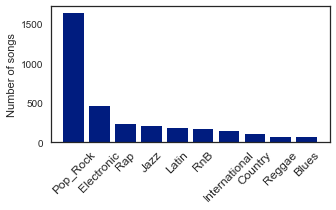

In [5]:
fig4,ax4=plt.subplots(figsize=(5,2.5))
ax4.bar(np.arange(10),train_labels[0].value_counts())
ax4.set_xticks(np.arange(10))
ax4.set_xticklabels(genres, fontsize=12)
ax4.set_ylabel("Number of songs")
plt.xticks(rotation=45)

Train label distribution is very unbalanced as most songs are from the Pop_rock genre. The counter this lets do over-sampling with a borderline over-sampling method. The method creates samples at the borderline between the minority classes and the majority class in the training data, as the samples at the borderline are most critical for esti- mating the optimal decision boundary. In the algorithm, the borderlines are created by a support vector machine (SVM), which is trained on the original training dataset. New instances are then randomly created along the lines.

In [6]:
#Do over-sampling with SVM-SMOTE
fe, la = SMOTE(kind='svm').fit_sample(train_features, train_labels[0].values)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

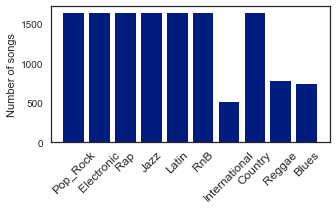

In [7]:
#Count number of song labeled to each genre in training dataset
countsmote=np.zeros(10)
for i in range(1,11):
    countsmote[i-1]=np.sum(la == i)
fig4,ax4=plt.subplots(figsize=(5,2.5))
ax4.bar(np.arange(10),countsmote)
ax4.set_xticks(np.arange(10))
ax4.set_xticklabels(genres, fontsize=12)
ax4.set_ylabel("Number of songs")
plt.xticks(rotation=45)

Oversampled training dataset looks now more balanced.

# Classification
Lets next try multiple different classification models <br>
Support vector machine<br>
Logistic Regression<br>
Xgboost Classifier<br>

Models are evaluated by the classification accuracy and logarithmic loss which are defined as<br>

$\mathrm{accuracy} = \frac{|y_{\mathrm{true}} - y_{\mathrm{predicted}}|}{N}$,<br>

$\mathrm{logloss} = -\frac{1}{N} \sum_{i=1}^{N}\sum_{j=1}^{M}y_{i,j}\log(p_{i,j})$,  <br>

where $N$ is the number of test data samples, M is the number of classes, $y_{i,j}$ is indicator which is 1 when sample $i$ is classified to class $j$, and $p_{i,j}$ are the predicted probability that sample $i$ belongs to class $j$.

The validation dataset is also imbalanced. Thus, a Cohen’s kappa score is also calculated as it takes into account the possibility of correct classification happening by chance.

First lets try SVM as it is effective in high dimensional spaces, and can perform a non-linear classification. The goal of SVM classification is to train a hyperplane  that  separates two classes with a maximum margin. The SVM does a mapping $\Phi$ from the input space to a high-dimensional feature space where data is linearly separable by performing a kernel trick. Consider a training set $\{\textbf{x}^{(i)},y^{(i)}\}, i = 1,...,N$ where $\textbf{x}^{(i)}$ is a training feature vector, $y^{(i)} = \{-1, +1\}$ is its true label, and $N$ is the number of samples. The primal SVM problem is then defined by minimization of:
\begin{equation}
\frac{1}{2}||\mathbf{w}||^{2} + C\sum_{i}\xi
\end{equation}
subject to
\begin{eqnarray*}
y^{(i)}(\mathbf{w} \cdot \Phi(\mathbf{x}^{(i)}) + b) \geq 1-\xi, \forall i \\
\xi \geq 0, \forall i, 
\end{eqnarray*}
where $\mathbf{w}$ and $b$ are  the  weight  vector  and  the  bias  of  the separating hyperplane, and $C$ is the penalty parameter. This problem can be solved by its dual problem which consists of maximizing
\begin{equation}
\sum_{i}\alpha^{(i)} -\frac{1}{2}\sum_{i,j}\alpha^{(i)}\alpha^{(j)}y^{(i)}y^{(j)}K(\mathbf{x}^{(i)},\mathbf{x}^{(j)})
\end{equation}
subject to
\begin{eqnarray*}
0 < \alpha^{(i)} < C, \forall i \\
\sum_{i}\alpha^{(i)}y^{(i)} = 0
\end{eqnarray*}
where $\alpha^{(i)}$'s are  the  Lagrangian  multipliers  corresponding  to
training instances, and $K(\mathbf{x}^{(i)},\mathbf{x}^{(j)})$ is a Kernel function, which allows the algorithm to fit the maximum-margin hyperplane in a transformed feature space. Thus, even if the classifier is a hyperplane in the transformed feature space, it can be nonlinear in the original feature space. For a multi-class classification the SVM problem is generalized into multiple binary classification problems. The classification can be performed between one of the labels and the rest, or between every pair of classes. Here I use the one vs rest approach.
The SVM is trained using the over-sampled datasets principal components. A 5-fold grid-search cross-validation is used to find optimal parameters for the SVM on the training dataset. The SVM is performed with a radial basis function kernel, which is defined as 
\begin{equation}
K(\mathbf{x}, \mathbf{x'}) = \exp(-\gamma\|\mathbf{x} - \mathbf{x'}\|^2),
\end{equation}
where values $\gamma = 0.002$ and a penalty parameter $C = 11$ are used.


In [8]:
#Support Vector Machine one vs rest approach
modelSVC = svm.SVC(kernel='rbf', C=1, gamma=0.002,probability=True,decision_function_shape ='ovr')
#train model
modelSVC.fit(fe, la.ravel())
predicted_labels = modelSVC.predict(validation_features)
#Predicted propability
predicted_prob=modelSVC.predict_proba(validation_features)
cm_SVC=confusion_matrix(validation_labels[0].values, predicted_labels)
svm_accuracy=accuracy_score(validation_labels[0].values, predicted_labels)
loglossSVM=log_loss(validation_labels[0].values, predicted_prob)
print("FINISHED classifying. accuracy score : ") 
print(svm_accuracy) 
print("Cohen kappa score : ")
print(cohen_kappa_score(validation_labels[0].values, predicted_labels))
print("Confusion matrix : ")
print(cm_SVC)
print("Log loss : ")
print(loglossSVM)

FINISHED classifying. accuracy score : 
0.662694775435
Cohen kappa score : 
0.526963865557
Confusion matrix : 
[[431  27   8   6  15  18   6  21   2   1]
 [ 38 101   4   7   2   1   1   0   2   0]
 [  7   9  70   3   1   4   1   0   0   0]
 [ 10   2   2  27   2   5   0   0   0   0]
 [ 21   2   1   1  20   2   1   2   1   1]
 [  6   3   8   8   6  36   0   3   0   3]
 [ 15   2   3   3   7   5   1   4   0   2]
 [ 13   0   1   0   1   4   1  25   0   2]
 [  1   2   8   1   1   1   0   0  10   0]
 [  6   0   1   4   3   0   1   2   0   2]]
Log loss : 
1.12715646414


In [9]:
#Calculate labels and log_loss for test data
test_data_scaled=scaler.transform(test_data)
submit_labels_SVC=modelSVC.predict(test_data_scaled)
submit_log_loss_SVC=modelSVC.predict_proba(test_data_scaled)
ids=list(range(1,len(submit_labels_SVC)+1))

In [10]:
#Count number of song labeled to each genre in
countSVC=np.zeros(10)
countsmote=np.zeros(10)
print("Support Vector Machine predictions")
for i in range(1,11):
    countSVC[i-1]=np.sum(submit_labels_SVC == i)

Support Vector Machine predictions


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

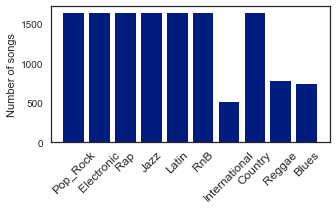

In [11]:
#Count number of predicted labels for each genre in test dataset
countsmote=np.zeros(10)
for i in range(1,11):
    countsmote[i-1]=np.sum(la == i)
fig4,ax4=plt.subplots(figsize=(5,2.5))
ax4.bar(np.arange(10),countsmote)
ax4.set_xticks(np.arange(10))
ax4.set_xticklabels(genres, fontsize=12)
ax4.set_ylabel("Number of songs")
plt.xticks(rotation=45)

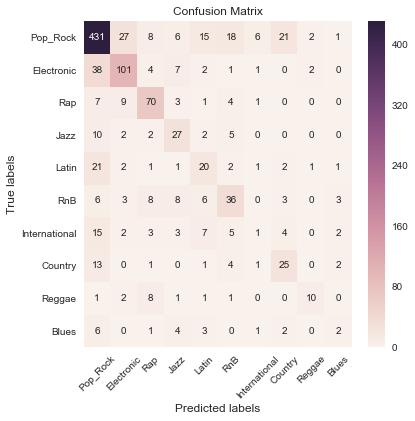

In [12]:
#Create confusion matrix heatmap
df_cm_SVC = pd.DataFrame(cm_SVC, index = [i for i in genres],
                  columns = [i for i in genres])
fig1=plt.figure(figsize = (6,6))
ax1 = plt.axes()
plt.xticks(rotation=45)
heatmap=sns.heatmap(df_cm_SVC, annot=True,ax=ax1, fmt='g')
plt.xticks(rotation=45)
ax1.set_title("Confusion Matrix", fontsize=12)
ax1.set_xlabel("Predicted labels", fontsize=12)
ax1.set_ylabel("True labels", fontsize=12)

In [14]:
#Logistic Regression classifier
clf = linear_model.LogisticRegression(C=1,
                         multi_class='ovr',
                          solver='sag', tol=0.01)
clf.fit(fe, la.ravel())
predicted_labels=clf.predict(validation_features)
#clf.fit(train_new, train_labels[0].values)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(validation_features, validation_labels[0].values)
#score = clf.score(test_new, validation_labels[0].values)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)
print("Cohen kappa score : ")
print(cohen_kappa_score(validation_labels[0].values, predicted_labels))
print("Confusion matrix : ")
print(confusion_matrix(validation_labels[0].values, predicted_labels))

Sparsity with L1 penalty: 0.00%
Test score with L1 penalty: 0.5875
Cohen kappa score : 
0.46344438215
Confusion matrix : 
[[349  25  14  21  21  28  13  43  11  10]
 [ 22  92  10  14   3   3   3   1   5   3]
 [  5   7  71   2   2   2   1   0   3   2]
 [  5   2   3  27   3   5   0   1   0   2]
 [ 15   2   3   2  16   3   1   6   3   1]
 [  3   1  10   8   6  35   1   1   2   6]
 [  6   2   2   5   6   6   4   6   1   4]
 [  7   1   1   1   0   4   0  31   2   0]
 [  1   1   6   0   2   1   0   0  12   1]
 [  3   0   1   5   2   0   1   2   1   4]]


In [18]:
#XGboost classifier
model_xgb = xgb.XGBClassifier(max_depth=6, n_estimators=300,learning_rate=0.05,min_child_weight = 1.5, colsample_bytree = 0.3,objective='multi:softmax')
model_xgb.fit(fe, la.ravel())
predicted_labels  = model_xgb.predict(validation_features)
predicted_prob=model_xgb.predict_proba(validation_features)
cm_xgb=confusion_matrix(validation_labels[0].values, predicted_labels)
xgb_accuracy=accuracy_score(validation_labels[0].values, predicted_labels)
print("FINISHED classifying. accuracy score : ") 
print(xgb_accuracy) 
print("Cohen kappa score : ")
print(cohen_kappa_score(validation_labels[0].values, predicted_labels))
print("Confusion matrix : ")
print(cm_xgb)
print("Log loss : ")
print(log_loss(validation_labels[0].values, predicted_prob))

FINISHED classifying. accuracy score : 
0.667277726856
Cohen kappa score : 
0.501685446275
Confusion matrix : 
[[471  20   8   7   9  12   0   8   0   0]
 [ 45  95   5   7   1   2   0   0   1   0]
 [ 15   9  62   3   2   4   0   0   0   0]
 [ 17   1   1  25   2   2   0   0   0   0]
 [ 27   2   2   1  13   3   0   2   2   0]
 [ 25   1   6   2   5  31   0   0   0   3]
 [ 27   3   2   2   4   0   1   1   0   2]
 [ 23   0   1   3   1   1   0  18   0   0]
 [  3   2   7   0   1   0   1   0  10   0]
 [ 11   0   1   5   0   0   0   0   0   2]]
Log loss : 
1.07672563366


All of the used classification models seemed to perform quite similarly with SVM getting about 63% accuracy in test dataset. Logistic Regression is worked bit worse than SVM or XGB. In the dataset, the Pop Rock class is the majority which creates a problem for classifying the smallest class, Blues, as blues songs have similar timbral, rhythmic and pitch-related characteristics as rock songs. The most commonly misclassified class is International which is likely due to that the international music genre is a category which includes many different types of music: the genre consists of folk and ethnic music from around the globe.